# BDA Mini Project 

## Chicago Traffic Crash Analysis

### Team Members : Mudit Gupta , Kshitij Sohni , Shaniaa Sen , Yajurva Toshniwal

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
import findspark
findspark.init()

spark = SparkSession.builder \
    .appName("Chicago Traffic Crashes Analysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()


In [4]:
spark.sparkContext.setLogLevel("WARN")

In [6]:
filePath = """/user/bda/chicago_crashes.csv"""

crashes_df = spark.read.csv(filePath, 
                          header=True, 
                          inferSchema=True,
                          escape='"')

In [7]:
crashes_df.printSchema()


root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- CRASH_DATE_EST_I: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- LANE_CNT: integer (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- INTERSECTION_RELATED_I: string (nullable = true)
 |-- NOT_RIGHT_OF_WAY_I: string (nullable = true)
 |-- HIT_AND_RUN_I: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED: string (nullable = true)
 |-- PRIM_

#### Data Pre-processing

In [9]:
from pyspark.sql.functions import col, to_timestamp, hour, dayofweek, month, when

processed_df = crashes_df.withColumn(
    "CRASH_DATE_TS", to_timestamp(col("CRASH_DATE"), "MM/dd/yyyy hh:mm:ss a")) \
    .withColumn("HOUR", hour(col("CRASH_DATE_TS"))) \
    .withColumn("DAY_OF_WEEK", dayofweek(col("CRASH_DATE_TS"))) \
    .withColumn("MONTH", month(col("CRASH_DATE_TS"))) \
    .withColumn("SEASON", when((col("MONTH") >= 3) & (col("MONTH") <= 5), "Spring")
                .when((col("MONTH") >= 6) & (col("MONTH") <= 8), "Summer")
                .otherwise("Fall/Winter")) \
    .withColumn("CRASH_SEVERITY", when(col("INJURIES_TOTAL") > 0, 1).otherwise(0)) \
    .fillna({
        'PRIM_CONTRIBUTORY_CAUSE': 'UNKNOWN',
        'WEATHER_CONDITION': 'UNKNOWN',
        'LIGHTING_CONDITION': 'UNKNOWN',
        'ROADWAY_SURFACE_COND': 'UNKNOWN',
        'TRAFFICWAY_TYPE': 'UNKNOWN'
    })

#### Top 10 Contributing Causes of Crash

/tmp/ipykernel_15585/2114340851.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='PRIM_CONTRIBUTORY_CAUSE', data=top_causes, palette="rocket")


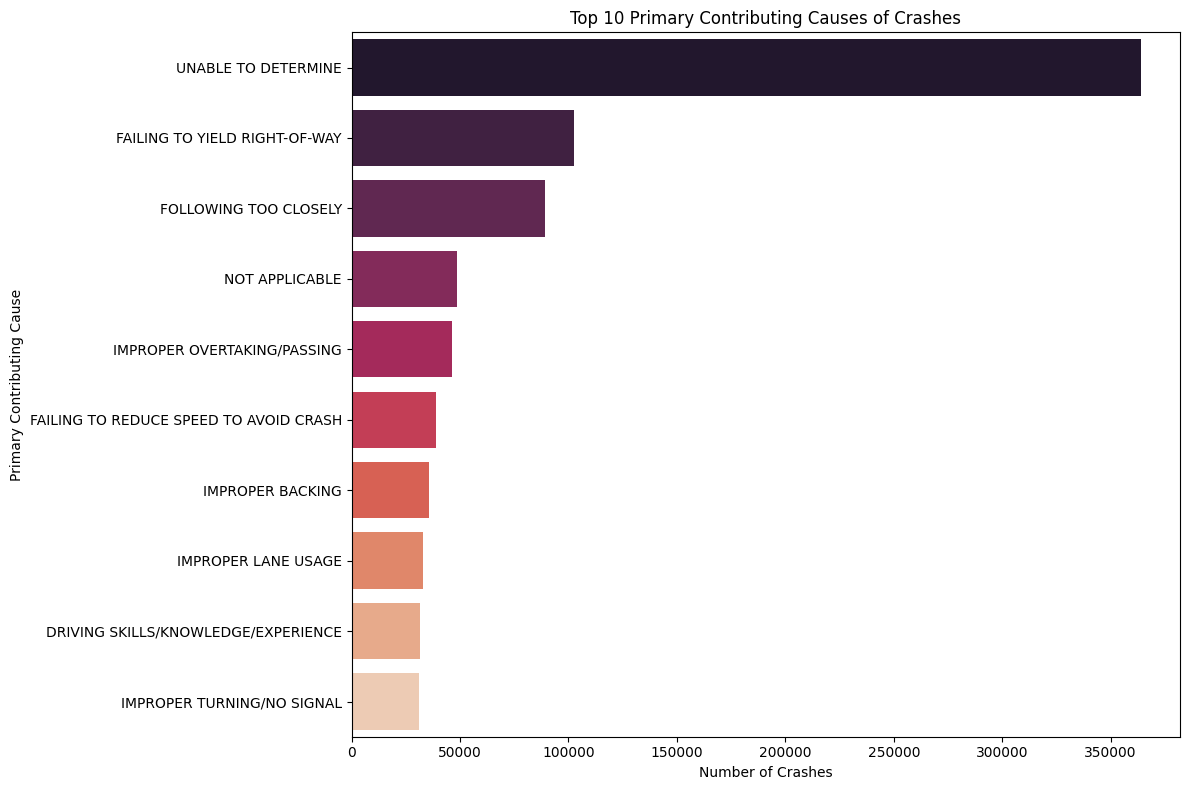

In [12]:
top_causes = processed_df.groupBy("PRIM_CONTRIBUTORY_CAUSE") \
    .count() \
    .orderBy(desc("count")) \
    .limit(10) \
    .toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='PRIM_CONTRIBUTORY_CAUSE', data=top_causes, palette="rocket")
plt.title('Top 10 Primary Contributing Causes of Crashes')
plt.xlabel('Number of Crashes')
plt.ylabel('Primary Contributing Cause')
plt.tight_layout()
plt.savefig('top_causes.png', bbox_inches='tight')


#### Hourly crash distribution

/tmp/ipykernel_15585/2336350118.py:3: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='HOUR', y='count', data=hourly_counts, palette="viridis")


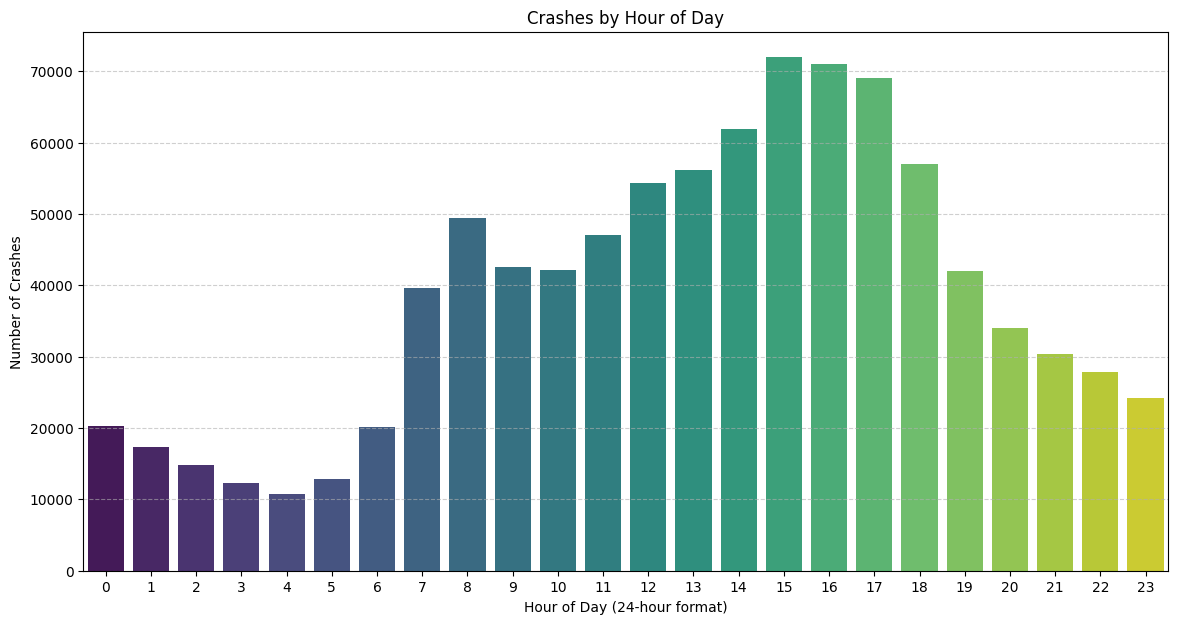

In [13]:
hourly_counts = processed_df.groupBy("HOUR").count().orderBy("HOUR").toPandas()
plt.figure(figsize=(14, 7))
sns.barplot(x='HOUR', y='count', data=hourly_counts, palette="viridis")
plt.title('Crashes by Hour of Day')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Crashes')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig('crashes_by_hour.png', bbox_inches='tight')

#### Crash Severity by Weather Condition

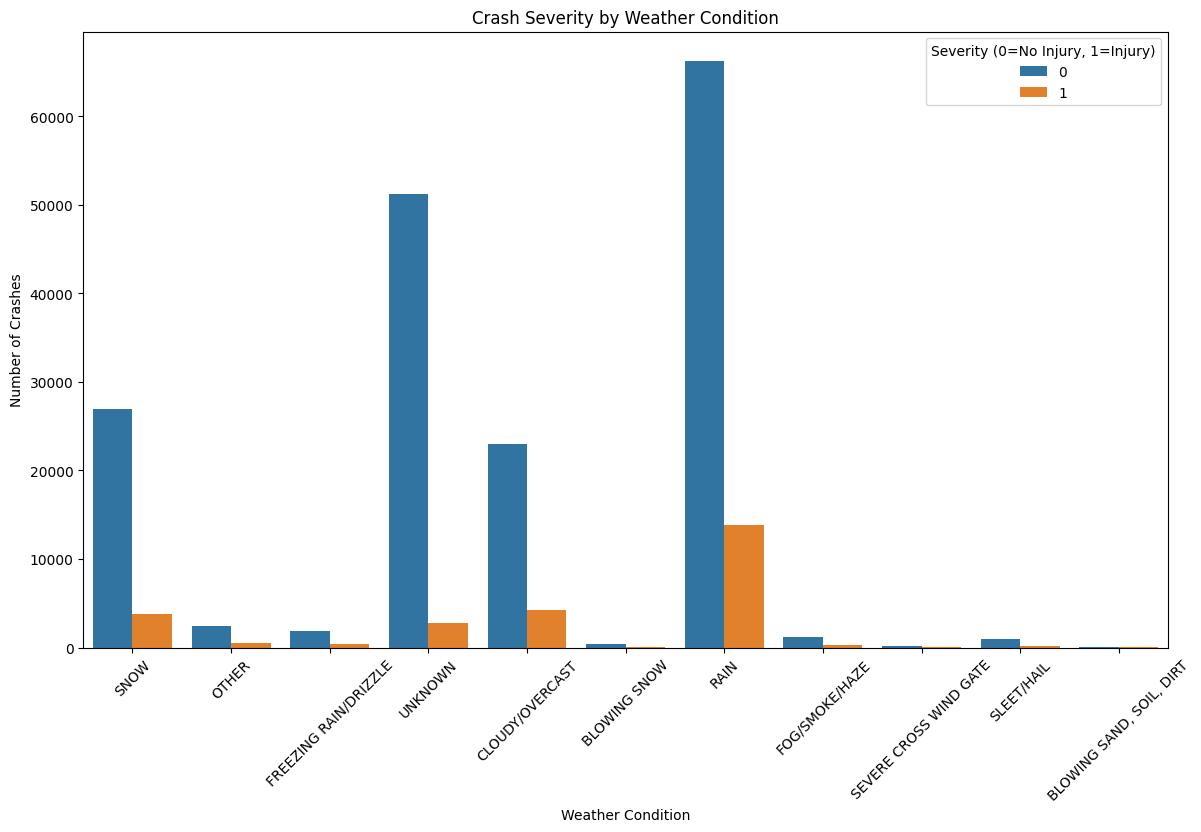

In [14]:
weather_severity = processed_df.filter(col("WEATHER_CONDITION") != "CLEAR") \
    .groupBy("WEATHER_CONDITION", "CRASH_SEVERITY") \
    .count() \
    .toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(x='WEATHER_CONDITION', y='count', hue='CRASH_SEVERITY', data=weather_severity)
plt.title('Crash Severity by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Crashes')
plt.legend(title='Severity (0=No Injury, 1=Injury)')
plt.xticks(rotation=45)
plt.savefig('weather_severity.png', bbox_inches='tight')

#### Feature Selection

In [15]:
ml_data = processed_df.select(
    'CRASH_SEVERITY',
    'HOUR',
    'DAY_OF_WEEK',
    'MONTH',
    'SEASON',
    'PRIM_CONTRIBUTORY_CAUSE',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'ROADWAY_SURFACE_COND',
    'TRAFFICWAY_TYPE'
).na.drop()

#### Preprocessing

In [16]:
# Convert severity to double type for ML
ml_data = ml_data.withColumn("CRASH_SEVERITY", col("CRASH_SEVERITY").cast(DoubleType()))

# Feature Engineering
categorical_cols = [
    'SEASON',
    'PRIM_CONTRIBUTORY_CAUSE',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'ROADWAY_SURFACE_COND',
    'TRAFFICWAY_TYPE'
]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep") 
            for col in categorical_cols]

encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_enc") 
            for col in categorical_cols]

numerical_cols = ['HOUR', 'DAY_OF_WEEK', 'MONTH']

assembler = VectorAssembler(
    inputCols=numerical_cols + [f"{col}_enc" for col in categorical_cols],
    outputCol="features"
)

#### Predicting Crash Severity

In [17]:
rf = RandomForestClassifier(
    labelCol="CRASH_SEVERITY",
    featuresCol="features",
    numTrees=100,
    maxDepth=10,
    seed=42,
    subsamplingRate=0.8
)

pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

# Split data
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Train model
model = pipeline.fit(train_data)

2025-04-07 15:03:52,948 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1096.7 KiB
2025-04-07 15:03:55,378 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1839.7 KiB
2025-04-07 15:03:58,984 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 3.0 MiB
2025-04-07 15:04:04,260 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 4.6 MiB
2025-04-07 15:04:10,952 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 7.0 MiB
2025-04-07 15:04:17,780 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1146.3 KiB
                                                                                

#### Evaluating model 

In [18]:
# Evaluate model
predictions = model.transform(test_data)

evaluator = BinaryClassificationEvaluator(
    labelCol="CRASH_SEVERITY",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc = evaluator.evaluate(predictions)

print(f"\nModel Performance:")
print(f"AUC-ROC: {auc:.4f}")

2025-04-07 15:05:05,489 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
                                                                                


Model Performance:
AUC-ROC: 0.6903


#### Visualising Crash Prediction

/tmp/ipykernel_15585/2086781397.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette="mako")


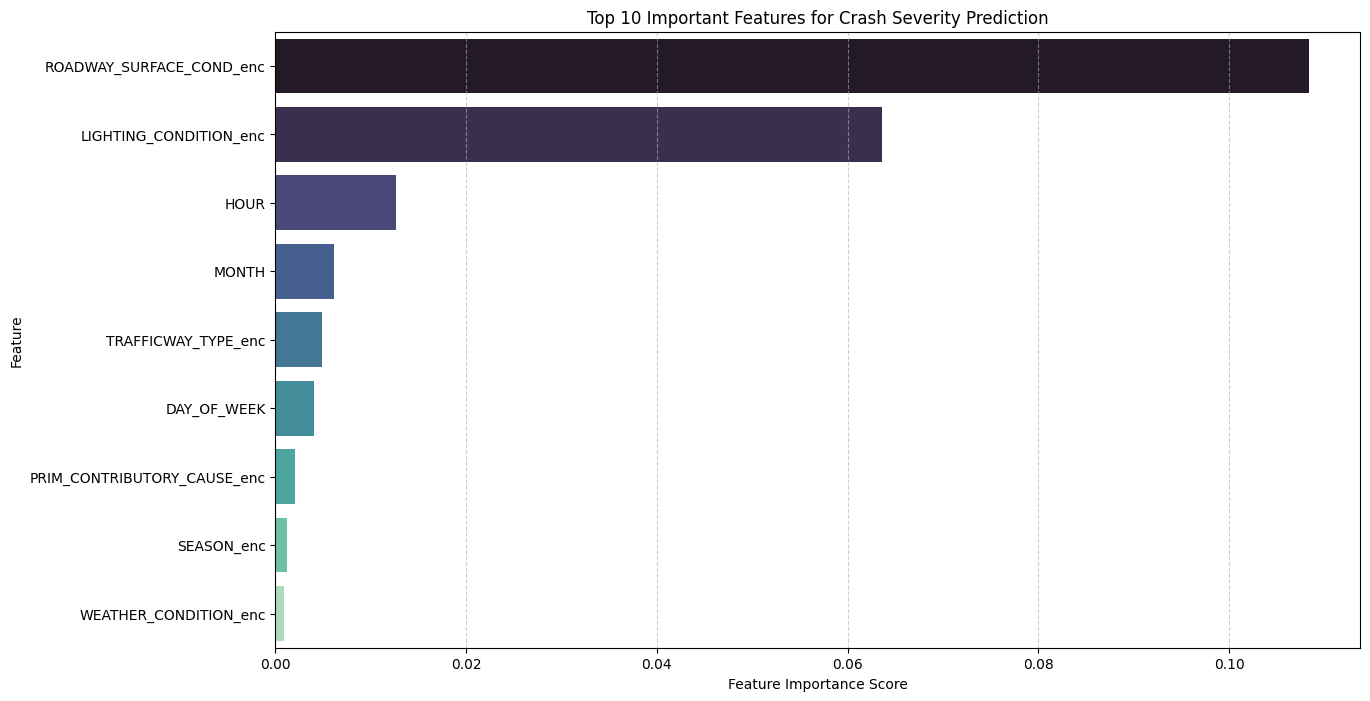

In [19]:
# Get the feature importances array
importances = model.stages[-1].featureImportances.toArray()

# Get all column names (features) used by the model
feature_names = ([col for col in numerical_cols] + 
                 [f"{col}_enc" for col in categorical_cols])

# Trim the longer array to match the shorter one
feature_names = feature_names[:len(importances)]
# OR
importances = importances[:len(feature_names)]

# Create DataFrame with matching lengths
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), palette="mako")
plt.title('Top 10 Important Features for Crash Severity Prediction')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig('feature_importances.png', bbox_inches='tight')

## Geospatial Crash Hotspot Classification

#### Preprocessing

In [21]:
df = processed_df.dropna(subset=['LATITUDE', 'LONGITUDE'])

#### Initialization 

In [22]:
from pyspark.sql import functions as F
from pyspark.sql.types import TimestampType

# Drop rows with null values in LATITUDE or LONGITUDE
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert CRASH_DATE to datetime
df = df.withColumn('CRASH_DATE', F.to_timestamp('CRASH_DATE'))

In [35]:
features = [
    'CRASH_HOUR',
    'CRASH_DAY_OF_WEEK',
    'CRASH_MONTH',
    'POSTED_SPEED_LIMIT',
    'TRAFFIC_CONTROL_DEVICE',
    'DEVICE_CONDITION',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE',
    'ROADWAY_SURFACE_COND',
    'ROAD_DEFECT'
]

In [23]:
# Drop columns in PySpark
drop_cols = [
    'CRASH_DATE_EST_I', 'LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I',
    'HIT_AND_RUN_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I',
    'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I'
]
df = df.drop(*drop_cols)

In [24]:
def get_mode(column_name):
    mode_df = df.groupBy(column_name).count()
    
    # Make sure SparkContext is properly set
    mode_df._sc = spark._sc
    
    # Get the mode value
    top_row = mode_df.orderBy(F.desc("count")).select(column_name).limit(1).collect()
    
    if len(top_row) > 0:
        return top_row[0][0]
    else:
        return None  # Return None or a default value if no data

report_type_mode = get_mode("REPORT_TYPE")
df = df.fillna({"REPORT_TYPE": report_type_mode})

In [25]:
# Create location bins
df = df.withColumn('lat_bin', F.floor(df['LATITUDE'] * 100).cast('integer'))
df = df.withColumn('lon_bin', F.floor(df['LONGITUDE'] * 100).cast('integer'))
df = df.withColumn('grid_id', 
    F.concat_ws('_', F.col('lat_bin').cast('string'), F.col('lon_bin').cast('string')))

In [26]:
# Count crashes by grid
crash_counts = df.groupBy('grid_id').count().withColumnRenamed('count', 'crash_count')

# Calculate threshold for hotspots (90th percentile)
threshold_value = crash_counts.approxQuantile('crash_count', [0.9], 0.001)[0]

# Create hotspot indicator
crash_counts = crash_counts.withColumn('is_hotspot', 
                                     F.when(F.col('crash_count') >= threshold_value, 1).otherwise(0))

# Join back to main dataframe
df = df.join(crash_counts.select('grid_id', 'is_hotspot'), on='grid_id')


#### Applying KMeans for Hotspot Clustering

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Sample data
coords = df.select('LATITUDE', 'LONGITUDE').na.drop().sample(False, 10000.0/df.count(), seed=1)

# Assemble features into vector format required by ML algorithms
assembler = VectorAssembler(inputCols=['LATITUDE', 'LONGITUDE'], outputCol='features')
coords_vector = assembler.transform(coords)

# Fit KMeans
kmeans = KMeans(k=20, seed=0, featuresCol='features', predictionCol='cluster')
model = kmeans.fit(coords_vector)
coords_with_cluster = model.transform(coords_vector)


#### Visualization

In [29]:
# Collect a sample of data to the driver for visualization
sample_df = df.select('LATITUDE', 'LONGITUDE').sample(False, 5000.0/df.count()).toPandas()

# Create folium map (runs on driver)
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[41.88, -87.63], zoom_start=11, tiles='CartoDB positron')
marker_cluster = MarkerCluster().add_to(m)

for _, row in sample_df.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=2,
        fill=True,
        color='blue',
        fill_opacity=0.5
    ).add_to(marker_cluster)

# Display map
m

#### Preparing the Classification model 

In [32]:
# Prepare data
df_model = df.select(features + ['is_hotspot']).na.drop()

# Process categorical features
categorical_features = [
    'CRASH_DAY_OF_WEEK',
    'TRAFFIC_CONTROL_DEVICE',
    'DEVICE_CONDITION',
    'WEATHER_CONDITION',
    'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE',
    'ROADWAY_SURFACE_COND',
    'ROAD_DEFECT'
]

numeric_features = [
    'CRASH_HOUR',
    'CRASH_MONTH',
    'POSTED_SPEED_LIMIT'
]

[Stage 329:>                                                      (0 + 16) / 16]

Accuracy: 0.7122441222783298


#### Preprocessing

In [ ]:
# Define stages for the pipeline
stages = []

# Process categorical features
for categorical_col in categorical_features:
    # Convert string to index
    string_indexer = StringIndexer(inputCol=categorical_col, 
                                  outputCol=categorical_col + "_index",
                                  handleInvalid="keep")
    
    # Convert indices to one-hot encodings
    encoder = OneHotEncoder(inputCols=[categorical_col + "_index"],
                           outputCols=[categorical_col + "_vec"],
                           dropLast=True)
    
    stages += [string_indexer, encoder]

In [ ]:
# Assemble all features into a single vector
assembler_inputs = [c + "_vec" for c in categorical_features] + numeric_features
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [assembler]

# Create and fit the pipeline
pipeline = Pipeline(stages=stages)
model_pipeline = pipeline.fit(df_model)
prepared_data = model_pipeline.transform(df_model)

# Convert label to index
label_indexer = StringIndexer(inputCol="is_hotspot", outputCol="label")
prepared_data = label_indexer.fit(prepared_data).transform(prepared_data)

#### Training the model 

In [33]:
# Split data
train_data, test_data = prepared_data.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)
rf_model = rf.fit(train_data)

# Make predictions
predictions = rf_model.transform(test_data)

In [34]:
# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", 
                                            metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

[Stage 374:>                                                      (0 + 16) / 16]

Accuracy: 0.7122441222783298
